# GAN on MNIST DATASET

## Overview

Let's create a simple GAN that will work on MNIST data.
 
 The goal of this model is to generate data that will look very similar to the original dataset
 
 ### How does it works ?
 
 The model is actually made of 2 models that work against each other to make progress : 
     - a generator that generate data
     - a discriminator that evaluate the data to know if it's close to the real data
 
 To make it short while training the discriminator will get better at seeing if the data coming out 
 of the generator is real or fake and the generator will get better at making data that looks more and 
 more like the real one.
 
 In the end after training the generator is able to generate totally new data which is really close the 
 original dataset it's been trained on. So the one we are going to make here will be able to create totally
 new handwritten digits like the one contained in the MNSIT dataset
 
 articles : 
 - https://towardsdatascience.com/understanding-generative-adversarial-networks-4dafc963f2ef
 - https://github.com/soumith/ganhacks
 
 I didn't used all of the recommendation because I tried to keep a model as simple as possible
 
 
 ## Plan 
 
 Fisrt Let's create and train the model then we'll vizualize output and trainings with plots

In [1]:
# Dependencies
import pickle as pkl # to save images
import numpy as np # math
import tensorflow as tf # ML framework

# import the data set
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data')


# HyperParameters
    # for function
input_shape = 784
sample_shape = 100
g_hidden_layer_neurons = 128
d_hidden_layer_neurons = 128
alpha = 0.01
smooth = 0.1
    # for training
learning_rate = 0.001
batch_size  = 100
epochs = 200


# This function create the placeholders : 
# One that'll contains the real data to feed to the discriminator : "real"
# One that'll contains the random sample data that'll flow into the generator : "sample"
def inputs (real_dim, sample_dim):
    real = tf.placeholder(tf.float32, shape=[None, real_dim], name="Real_Data_Input")
    sample = tf.placeholder(tf.float32, shape=[None, sample_dim], name="Random_Sample_Input")
    
    return real, sample

# Now let's create the variables of our two models :
# Let's start with the generator
def generator (sample, out_dim, hidden_layer_neurons=128, reuse=False, alpha=alpha):
    with tf.variable_scope('generator', reuse=reuse):
        # hidden layer
        layer1 = tf.layers.dense(sample, hidden_layer_neurons, activation=None)
        # activation function
        layer1 = tf.maximum(layer1, alpha*layer1)
        
        # logits and tanh 
        logits = tf.layers.dense(layer1, out_dim, activation=None)
        out = tf.nn.tanh(logits)
        
        return out, logits
    
def discriminator (real, hidden_layer_neurons=128, reuse=False, alpha=alpha):
    with tf.variable_scope('discriminator', reuse=reuse):
        # hidden layer
        layer1 = tf.layers.dense(real, hidden_layer_neurons, activation=None)
        # activation function
        layer1 = tf.maximum(layer1, alpha*layer1)
        
        #logits and out 
        logits = tf.layers.dense(layer1, 1, activation=None)
        out = tf.nn.sigmoid(logits)
        
        return out, logits
    

# Creation of the network
tf.reset_default_graph()
    # Placeholders
real, sample = inputs(input_shape, sample_shape)
    # Generator
g_output, g_logits = generator(sample, input_shape, g_hidden_layer_neurons, reuse=False, alpha=alpha)
    #Discriminator
d_output_real, d_logits_real = discriminator(real, d_hidden_layer_neurons, reuse=False, alpha=alpha)
d_output_fake, d_logits_fake = discriminator(g_output, d_hidden_layer_neurons, reuse=True, alpha=alpha)

# Loss error of the model
    # discriminator loss is the sum of the real and fake
    # 1 for true image Smoothing the label is a good tweak to make the model perform better
    # tf.one_like() ouput a matrix of same shape as the given argument filled with one
    # 0 if not
    # tf.zeros_like() ouput a matrix of same shape as the given argument filled with zeros
d_loss = tf.reduce_mean(\
                        tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(d_logits_real)*(1-smooth), logits=d_logits_real)\
                        +\
                        tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(d_logits_fake)*smooth, logits=d_logits_fake)\
                       )
    # generator loss
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(d_logits_fake), logits=d_logits_fake))



# Optimization
# Get the trainable_variables, and separate them based if they're from the generator or the discriminator
all_variables = tf.trainable_variables()
g_variables = [var for var in all_variables if var.name.startswith("generator")]
d_variables = [var for var in all_variables if var.name.startswith("discriminator")]

d_train = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_variables)
g_train = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_variables)

# Actual Training
samples = [] # Table to keep samples of image produced by generator during the training
losses = [] # Table To keep trace of the loss to analyze it after training if wanted
saver = tf.train.Saver(var_list = all_variables) # Creation of the saver to save the trained variables

init= tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(epochs):
        for epoch_batch in range(int(mnist.train.num_examples/batch_size)):
            batch = mnist.train.next_batch(batch_size)
            
            # real data reshape and rescale before going to discriminator
            batch_real = batch[0].reshape((batch_size, 784)) # value of pixel between 0 and 1
            batch_real = batch_real*2 - 1 # because of tanh we need to have the image between -1 and 1
            
            # random sample for the generator
            batch_sample = np.random.uniform(-1, 1, size=(batch_size, sample_shape))
            
            # Run optimizers
            _ = sess.run(d_train, feed_dict={real: batch_real, sample: batch_sample})
            _ = sess.run(g_train, feed_dict={sample: batch_sample})
        
        # At the end of each epoch, get the losses and print them out
        train_loss_d = sess.run(d_loss, feed_dict={real: batch_real, sample: batch_sample})
        train_loss_g = g_loss.eval({sample: batch_sample})
            
        print("Epoch ",epoch+1,"/", epochs,"    Discriminator Loss: ",train_loss_d,"    Generator Loss: ",train_loss_g)    
        # Save losses into the table keep traces of it
        losses.append((train_loss_d, train_loss_g))
        
        # Sample of images from the generator during training to analyze it after if wanted
        sample_ex = np.random.uniform(-1, 1, size=(16, sample_shape))
        g_samples = sess.run(\
                       generator(sample, input_shape, reuse=True),\
                       feed_dict={sample: sample_ex})
        samples.append(g_samples)
        
        # save the generator with the created saver to be able to restore it for future utilization
        saver.save(sess, '../GAN/generator.ckpt')
        
# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Epoch  1 / 200     Discriminator Loss:  0.353834     Generator Loss:  3.96252
Epoch  2 / 200     Discriminator Loss:  0.434138     Generator Loss:  4.05455
Epoch  3 / 200     Discriminator Loss:  0.33904     Generator Loss:  4.91147
Epoch  4 / 200     Discriminator Loss:  0.366384     Generator Loss:  3.85473
Epoch  5 / 200     Discriminator Loss:  0.47165     Generator Loss:  2.78074
Epoch  6 / 200     Discriminator Loss:  0.572237     Generator Loss:  3.24862
Epoch  7 / 200     Discriminator Loss:  0.746175     Generator Loss:  4.84893
Epoch  8 / 200     Discriminator Loss:  0.750285     Generator Loss:  4.28745
Epoch  9 / 200     Discriminator Loss:  1.17803     Generator Loss:  3.8911
Epoch  10 / 200     Discriminator Loss:  1.13238     Generator Loss:  2.24542
Epoch  11 / 200     Discrimina

## Now let's vizualize how the model trained :

 - Let's plot the loss of the generator and the discriminator to see the interaction (How they challenge each other)
 - Then we'll plot the samples we saved during training at each step and display some of them to see 
 how the generator output have evolved.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


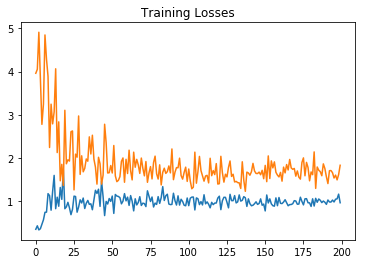

In [2]:
import matplotlib.pyplot as plt # to plot
%matplotlib inline

fig, ax = plt.subplots()
losses = np.array(losses)
plt.title("Training Losses")
plt.legend()
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')

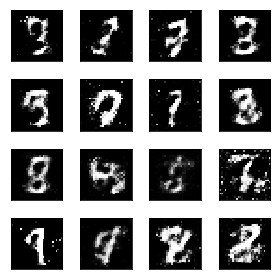

In [3]:
# Load samples from generator taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

# Plot them choose a training step and see how the generator output evolve
def visualize_training_step_output(step):
    step = step
    plt.figure(figsize=(4, 4))
    i = 0
    while i < 16:
            img = samples[step][0][i]/2+1
            img = img.reshape((28,28)) 
            plt.subplot(4, 4, i+1)
            plt.imshow(img, cmap='gray')
            plt.xticks([])
            plt.yticks([])
            i = i + 1
    plt.tight_layout()
    plt.show()

# Coose the step you want to vizualize : 100step but index start at 0 so 99 is the last step and 0 the first
visualize_training_step_output(99)

## Finally let's test our generator :

 We will provide him with random input and see if it's able to really create MNIST handwritten digits out of them.

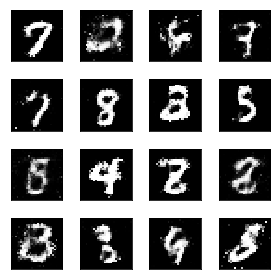

In [4]:
saver =  tf.train.Saver(var_list=all_variables)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('../GAN', 'checkpoint'))
    
    # Random sample we will feed into the restored generator
    sample_z =  np.random.uniform(-1, 1, size=(16, sample_shape))
    gen_samples = sess.run(
                   generator(sample, input_shape, reuse=True),
                   feed_dict={sample: sample_z})
    
    # Let's plot the output
    plt.figure(figsize=(4, 4))
    i = 0
    while i < 16:
            img = gen_samples[0][i]/2+1
            img = img.reshape((28,28)) 
            plt.subplot(4, 4, i+1)
            plt.imshow(img, cmap='gray')
            plt.xticks([])
            plt.yticks([])
            i = i + 1
    plt.tight_layout()
    plt.show()